In [1]:
%config Completer.use_jedi = False

In [2]:
import nibabel as nib
%matplotlib inline

import SimpleITK as sitk

import numpy as np 
import pandas as pd 

from skimage import io, color
from matplotlib import pyplot


import os
import scipy.ndimage
import matplotlib.pyplot as plt

from torch import nn
import torch

from torch.utils.data import DataLoader, Dataset, Sampler
import segmentation_models_pytorch as smp
from IPython.display import clear_output

import albumentations as albu

%matplotlib inline

/home/vess/dist/crt/lib/python3.8/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [3]:
img = nib.load('/data/datasets/test_task_cmai/Brain_CT_labeling/1.nii.gz')
img_seg = nib.load('/data/datasets/test_task_cmai/Brain_CT_labeling/1-seg.nii.gz')

In [4]:
directory = '/data/datasets/test_task_cmai/Brain_CT_labeling/'

segs = []
imgs = []
txts = []

for filename in os.listdir(directory):
    if filename.endswith(".gz") or filename.endswith(".nii"):
            if "seg" in filename:
                segs.append(filename)
            else:
                imgs.append(filename)
    elif filename.endswith(".txt"):
        txts.append(filename)

In [5]:
sorted(txts)

['1.txt', '2.txt', '3.txt', '4.txt', '5.txt', '6.txt', '7.txt']

In [6]:
def show_slices(slices):
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower") 

In [7]:
class CustomSampler(Sampler):
    """
    Implementation of Torch's Sampler
    """
    def __init__(self, dataset, size):
        
        self.size = size
        self.dataset = dataset
        self.classes_mapping = {}
        
        for i in range(len(dataset.slices)):
            data_slice = dataset.slices[i]
            classes = np.unique(data_slice["mask"])
            
            for s_class in classes:
                if s_class in self.classes_mapping:
                    self.classes_mapping[s_class].append(i)
                else:
                    self.classes_mapping[s_class] = [i]
        
    def __iter__(self):
        
        class_choices = [np.random.choice(sampler.classes_mapping[i], self.size) for i in sampler.classes_mapping]
        all_indexes = np.concatenate(class_choices);
        np.random.shuffle(all_indexes)
        return iter(all_indexes)
        
    def __len__(self):
        return len(self.classes_mapping) * self.size

    

In [8]:
class BrainDataset(Dataset):
    """
    Implementation of Torch's Dataset
    """
    
    CLASSES = [str(i + 1) for i in range(20)]
    
    def __init__(self, path, image_files, segm_files, txt_transformations,
                 classes = None,
                 augmentation=None):
        self.path = path
        self.image_files = image_files
        self.segm_files = segm_files
        self.txt_transformations = txt_transformations
        self.augmentation = augmentation
        self.imgs3D = []
        self.masks3D = []
        self.slices = []
        self.class_values = [int(cls) for cls in classes]
        
        for (img, seg, transf) in zip(self.image_files, self.segm_files, self.txt_transformations):
            try:
                image_data, seg_data = self.get_array_data(path+img, path+seg, path + transf)
                seg_data[seg_data > 10] -= 10 # 
                self.imgs3D.append(image_data)
                self.masks3D.append(seg_data)
            except:
                continue
                
            for i in range(image_data.shape[2]):
                
                slice_image = image_data[...,i]
#                 slice_image = (np.clip(slice_image, -200, 300) -36) / 16
            
                self.slices.append({
                                    "image": slice_image, #.astype(np.long), 
                                     "mask": seg_data[...,i]  #.astype(np.long)
                                    })
            
    
    def __getitem__(self, idx):
        
        if idx >= len(self.slices):
            raise IndexError("list index out of range")
            
        item = self.slices[idx]
        image, mask = item["image"], item["mask"]
        
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        masks = [(mask == v) for v in self.class_values]
        #mask = np.stack(masks, axis=-1).astype(np.int)
        mask= np.stack(masks, axis=-3).astype(np.int)
        
        image = (np.clip(image, -200, 300) -36) / 16

        return image.reshape(1, 512, 512).astype(np.float32), mask #.reshape(20, 512, 512).astype(np.int)
        
    def __len__(self):
        return len(self.slices)
    
    def get_array_data(self, img_path, seg_path, transf_path, visualise=False):
        """
        retrieving data from files + rotation
        """
        
        transform = self.read_transform_txt(transf_path)
        image = sitk.ReadImage(img_path)
        seg = sitk.ReadImage(seg_path)

        rot_matrix = transform[:3, :-1]
        offset = transform[:3,-1:]

        e3d_transform = sitk.Euler3DTransform()
        e3d_transform.SetMatrix(rot_matrix.flatten())
        e3d_transform.SetTranslation(offset.reshape(3))
        e3d_transform.TransformPoint([0,0,0])

        image = sitk.Resample(image, e3d_transform, sitk.sitkNearestNeighbor, defaultPixelValue = -1024 )
        image_data = sitk.GetArrayFromImage(image)
        image_data = np.moveaxis(image_data, 0, -1)
    
        seg_data = sitk.GetArrayFromImage(seg)
        seg_data = np.moveaxis(seg_data, 0, -1)
        
        if visualise:
            slice_img = image_data[:, :, 55]
            slice_seg = seg_data[:, :, 55]
            show_slices([slice_img, slice_seg])
        
        return image_data, seg_data
    

    def read_transform_txt(self, path):
        """
        Readint transform .txt file into an affine matrix
        """
        transform = None
        with open( path, 'r' ) as f:
            for line in f:

                if line.startswith( 'Parameters:' ):
                    values = line.split( ': ' )[1].split( ' ' )
                    values = [float( e ) for e in values if ( e != '' and e != '\n' )]
                    transform_upper_left = np.reshape( values[0:9], ( 3, 3 ) )
                    translation = values[9:]


                if line.startswith( 'FixedParameters:' ):
                    values = line.split( ': ' )[1].split( ' ' )
                    values = [float( e ) for e in values if ( e != '' and e != '\n' )]
                    center = values


        offset = np.ones(4)
        for i in range(0, 3):

            offset[i] = translation[i] + center[i];

            for j in range(0, 3):

                offset[i] -= transform_upper_left[i][j] * center[i]

        transform = np.vstack((transform_upper_left, [0, 0, 0]))
        transform = np.hstack((transform, np.reshape( offset, (4, 1))))

        return transform

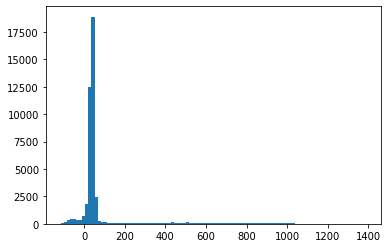

In [407]:
plt.hist(np.array(dataset[1]["image"])[..., 50][(np.array(dataset[1]["seg"])[..., 50] > 0)], 100);

In [10]:
def get_training_augmentation():
    train_transform = [
        albu.Flip(),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0, value=-1024),
        albu.Blur(blur_limit=3, p=0.9),
        albu.IAAAdditiveGaussianNoise(p=0.2),   
        
        albu.OneOf([
                albu.ElasticTransform(value=-1024, p=1.),
                albu.OpticalDistortion(value=-1024, p=1.),
                albu.GridDistortion(value=-1024, p=1.),
            ], .8),
    ]
    return albu.Compose(train_transform)

In [11]:
ALL_CLASSES = [str(i + 1) for i in range(10)]

In [12]:
ENCODER = 'efficientnet-b0'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'softmax2d' 
DEVICE = 'cuda'
CLASSES = ALL_CLASSES

model = smp.FPN(
    in_channels=1,
    decoder_dropout=.3,
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    activation='identity',
    classes=len(CLASSES),
)


In [13]:
dataset_train = BrainDataset(directory,
                             sorted(imgs)[:-1],
                             sorted(segs)[:-1],
                             sorted(txts)[:-1],
                             augmentation = get_training_augmentation(),
                             classes=CLASSES)

dataset_validation = BrainDataset(directory,
                                  [sorted(imgs)[-1]],
                                  [sorted(segs)[-1]],
                                  [sorted(txts)[-1]],
                                  classes=CLASSES)

sampler = CustomSampler(dataset_train, 300)

data_loader_train = DataLoader(dataset_train, batch_size=6, sampler=sampler)
data_loader_validation = DataLoader(dataset_validation, batch_size=6, shuffle=False)

In [13]:
dataset_train[150][1].shape

(10, 512, 512)

In [14]:
dataset_train.slices[144]["mask"].shape

(512, 512)

In [14]:
import math
import numpy as np

from typing import Optional

import torch
import torch.nn.functional as F


"""
Original code taken from https://github.com/qubvel/segmentation_models.pytorch
"""


__all__ = [
    "focal_loss_with_logits",
    "softmax_focal_loss_with_logits",
    "soft_jaccard_score",
    "soft_dice_score",
    "wing_loss",
]


def to_tensor(x, dtype=None) -> torch.Tensor:
    if isinstance(x, torch.Tensor):
        if dtype is not None:
            x = x.type(dtype)
        return x
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
        if dtype is not None:
            x = x.type(dtype)
        return x
    if isinstance(x, (list, tuple)):
        x = np.ndarray(x)
        x = torch.from_numpy(x)
        if dtype is not None:
            x = x.type(dtype)
        return x


def focal_loss_with_logits(
    output: torch.Tensor,
    target: torch.Tensor,
    gamma: float = 2.0,
    alpha: Optional[float] = 0.25,
    reduction: str = "mean",
    normalized: bool = False,
    reduced_threshold: Optional[float] = None,
    eps: float = 1e-6,
) -> torch.Tensor:
    """Compute binary focal loss between target and output logits.
    See :class:`~pytorch_toolbelt.losses.FocalLoss` for details.
    Args:
        output: Tensor of arbitrary shape (predictions of the model)
        target: Tensor of the same shape as input
        gamma: Focal loss power factor
        alpha: Weight factor to balance positive and negative samples. Alpha must be in [0...1] range,
            high values will give more weight to positive class.
        reduction (string, optional): Specifies the reduction to apply to the output:
            'none' | 'mean' | 'sum' | 'batchwise_mean'. 'none': no reduction will be applied,
            'mean': the sum of the output will be divided by the number of
            elements in the output, 'sum': the output will be summed. Note: :attr:`size_average`
            and :attr:`reduce` are in the process of being deprecated, and in the meantime,
            specifying either of those two args will override :attr:`reduction`.
            'batchwise_mean' computes mean loss per sample in batch. Default: 'mean'
        normalized (bool): Compute normalized focal loss (https://arxiv.org/pdf/1909.07829.pdf).
        reduced_threshold (float, optional): Compute reduced focal loss (https://arxiv.org/abs/1903.01347).
    References:
        https://github.com/open-mmlab/mmdetection/blob/master/mmdet/core/loss/losses.py
    """
    target = target.type(output.type())

    logpt = F.binary_cross_entropy_with_logits(output, target, reduction="none")
    pt = torch.exp(-logpt)

    # compute the loss
    if reduced_threshold is None:
        focal_term = (1.0 - pt).pow(gamma)
    else:
        focal_term = ((1.0 - pt) / reduced_threshold).pow(gamma)
        focal_term[pt < reduced_threshold] = 1

    loss = focal_term * logpt

    if alpha is not None:
        loss *= alpha * target + (1 - alpha) * (1 - target)

    if normalized:
        norm_factor = focal_term.sum().clamp_min(eps)
        loss /= norm_factor

    if reduction == "mean":
        loss = loss.mean()
    if reduction == "sum":
        loss = loss.sum()
    if reduction == "batchwise_mean":
        loss = loss.sum(0)

    return loss


def softmax_focal_loss_with_logits(
    output: torch.Tensor,
    target: torch.Tensor,
    gamma: float = 2.0,
    reduction="mean",
    normalized=False,
    reduced_threshold: Optional[float] = None,
    eps: float = 1e-6,
) -> torch.Tensor:
    """Softmax version of focal loss between target and output logits.
    See :class:`~pytorch_toolbelt.losses.FocalLoss` for details.
    Args:
        output: Tensor of shape [B, C, *] (Similar to nn.CrossEntropyLoss)
        target: Tensor of shape [B, *] (Similar to nn.CrossEntropyLoss)
        reduction (string, optional): Specifies the reduction to apply to the output:
            'none' | 'mean' | 'sum' | 'batchwise_mean'. 'none': no reduction will be applied,
            'mean': the sum of the output will be divided by the number of
            elements in the output, 'sum': the output will be summed. Note: :attr:`size_average`
            and :attr:`reduce` are in the process of being deprecated, and in the meantime,
            specifying either of those two args will override :attr:`reduction`.
            'batchwise_mean' computes mean loss per sample in batch. Default: 'mean'
        normalized (bool): Compute normalized focal loss (https://arxiv.org/pdf/1909.07829.pdf).
        reduced_threshold (float, optional): Compute reduced focal loss (https://arxiv.org/abs/1903.01347).
    """
    log_softmax = F.log_softmax(output, dim=1)

    loss = F.nll_loss(log_softmax, target, reduction="none")
    pt = torch.exp(-loss)

    # compute the loss
    if reduced_threshold is None:
        focal_term = (1.0 - pt).pow(gamma)
    else:
        focal_term = ((1.0 - pt) / reduced_threshold).pow(gamma)
        focal_term[pt < reduced_threshold] = 1

    loss = focal_term * loss

    if normalized:
        norm_factor = focal_term.sum().clamp_min(eps)
        loss = loss / norm_factor

    if reduction == "mean":
        loss = loss.mean()
    if reduction == "sum":
        loss = loss.sum()
    if reduction == "batchwise_mean":
        loss = loss.sum(0)

    return loss


def soft_jaccard_score(
    output: torch.Tensor, target: torch.Tensor, smooth: float = 0.0, eps: float = 1e-7, dims=None
) -> torch.Tensor:
    assert output.size() == target.size()
    if dims is not None:
        intersection = torch.sum(output * target, dim=dims)
        cardinality = torch.sum(output + target, dim=dims)
    else:
        intersection = torch.sum(output * target)
        cardinality = torch.sum(output + target)

    union = cardinality - intersection
    jaccard_score = (intersection + smooth) / (union + smooth).clamp_min(eps)
    return jaccard_score


def soft_dice_score(
    output: torch.Tensor, target: torch.Tensor, smooth: float = 0.0, eps: float = 1e-7, dims=None
) -> torch.Tensor:
    assert output.size() == target.size()
    if dims is not None:
        intersection = torch.sum(output * target, dim=dims)
        cardinality = torch.sum(output + target, dim=dims)
    else:
        intersection = torch.sum(output * target)
        cardinality = torch.sum(output + target)
    dice_score = (2.0 * intersection + smooth) / (cardinality + smooth).clamp_min(eps)
    return dice_score


def wing_loss(output: torch.Tensor, target: torch.Tensor, width=5, curvature=0.5, reduction="mean"):
    """
    https://arxiv.org/pdf/1711.06753.pdf
    :param output:
    :param target:
    :param width:
    :param curvature:
    :param reduction:
    :return:
    """
    diff_abs = (target - output).abs()
    loss = diff_abs.clone()

    idx_smaller = diff_abs < width
    idx_bigger = diff_abs >= width

    loss[idx_smaller] = width * torch.log(1 + diff_abs[idx_smaller] / curvature)

    C = width - width * math.log(1 + width / curvature)
    loss[idx_bigger] = loss[idx_bigger] - C

    if reduction == "sum":
        loss = loss.sum()

    if reduction == "mean":
        loss = loss.mean()

    return loss


def label_smoothed_nll_loss(
    lprobs: torch.Tensor, target: torch.Tensor, epsilon: float, ignore_index=None, reduction="mean", dim=-1
) -> torch.Tensor:
    """
    Source: https://github.com/pytorch/fairseq/blob/master/fairseq/criterions/label_smoothed_cross_entropy.py
    :param lprobs: Log-probabilities of predictions (e.g after log_softmax)
    :param target:
    :param epsilon:
    :param ignore_index:
    :param reduction:
    :return:
    """
    if target.dim() == lprobs.dim() - 1:
        target = target.unsqueeze(dim)

    if ignore_index is not None:
        pad_mask = target.eq(ignore_index)
        target = target.masked_fill(pad_mask, 0)
        nll_loss = -lprobs.gather(dim=dim, index=target)
        smooth_loss = -lprobs.sum(dim=dim, keepdim=True)

        # nll_loss.masked_fill_(pad_mask, 0.0)
        # smooth_loss.masked_fill_(pad_mask, 0.0)
        nll_loss = nll_loss.masked_fill(pad_mask, 0.0)
        smooth_loss = smooth_loss.masked_fill(pad_mask, 0.0)
    else:
        nll_loss = -lprobs.gather(dim=dim, index=target)
        smooth_loss = -lprobs.sum(dim=dim, keepdim=True)

        nll_loss = nll_loss.squeeze(dim)
        smooth_loss = smooth_loss.squeeze(dim)

    if reduction == "sum":
        nll_loss = nll_loss.sum()
        smooth_loss = smooth_loss.sum()
    if reduction == "mean":
        nll_loss = nll_loss.mean()
        smooth_loss = smooth_loss.mean()

    eps_i = epsilon / lprobs.size(dim)
    loss = (1.0 - epsilon) * nll_loss + eps_i * smooth_loss
    return loss

In [15]:
from typing import Optional, List

import torch
import torch.nn.functional as F
from torch.nn.modules.loss import _Loss


"""
Original code taken from https://github.com/qubvel/segmentation_models.pytorch
"""

class DiceLoss(_Loss):

    def __init__(
        self,
        mode: str,
        classes: Optional[List[int]] = None,
        log_loss: bool = False,
        from_logits: bool = True,
        smooth: float = 0.0,
        ignore_index: Optional[int] = None,
        eps: float = 1e-7,
    ):
        """Implementation of Dice loss for image segmentation task.
        It supports binary, multiclass and multilabel cases
        Args:
            mode: Loss mode 'binary', 'multiclass' or 'multilabel'
            classes:  List of classes that contribute in loss computation. By default, all channels are included.
            log_loss: If True, loss computed as `- log(dice_coeff)`, otherwise `1 - dice_coeff`
            from_logits: If True, assumes input is raw logits
            smooth: Smoothness constant for dice coefficient (a)
            ignore_index: Label that indicates ignored pixels (does not contribute to loss)
            eps: A small epsilon for numerical stability to avoid zero division error 
                (denominator will be always greater or equal to eps)
        Shape
             - **y_pred** - torch.Tensor of shape (N, C, H, W)
             - **y_true** - torch.Tensor of shape (N, H, W) or (N, C, H, W)
        Reference
            https://github.com/BloodAxe/pytorch-toolbelt
        """
        super(DiceLoss, self).__init__()
        self.mode = mode

        self.classes = classes
        self.from_logits = from_logits
        self.smooth = smooth
        self.eps = eps
        self.log_loss = log_loss

    def forward(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:

        assert y_true.size(0) == y_pred.size(0)

        if self.from_logits:
            # Apply activations to get [0..1] class probabilities
            # Using Log-Exp as this gives more numerically stable result and does not cause vanishing gradient on
            # extreme values 0 and 1
            y_pred = F.logsigmoid(y_pred).exp()

        bs = y_true.size(0)
        num_classes = y_pred.size(1)
        dims = (0, 2)

        y_true = y_true.view(bs, num_classes, -1)
        y_pred = y_pred.view(bs, num_classes, -1)

        scores = soft_dice_score(y_pred, y_true.type_as(y_pred), smooth=self.smooth, eps=self.eps, dims=dims)

        if self.log_loss:
            loss = -torch.log(scores.clamp_min(self.eps))
        else:
            loss = 1.0 - scores

        # Dice loss is undefined for non-empty classes
        # So we zero contribution of channel that does not have true pixels
        # NOTE: A better workaround would be to use loss term `mean(y_pred)`
        # for this case, however it will be a modified jaccard loss

        mask = y_true.sum(dims) > 0
        loss *= mask.to(loss.dtype)

        if self.classes is not None:
            loss = loss[self.classes]

        return loss.mean()

In [16]:
import torch
import numpy as np
import segmentation_models_pytorch as smp


class Loss(nn.Module):
    """
    BCE + LogDice loss implementation
    """
    def __init__(self):
        super(Loss, self).__init__()
        self.__name__ = 'BCE + LogDice loss'
        self.dice = DiceLoss(mode="multilabel", log_loss=True, from_logits=True)
        self.bce = torch.nn.BCEWithLogitsLoss()

    def forward(self, input, labels):
        bces = torch.mean(torch.stack([
            self.bce(input[:, i].flatten(), (labels[:, i].flatten() > 0).float())
            for i in range(input.size(1)) ]))

        return self.dice(input, labels) + bces
    
    
loss = Loss()

In [ ]:
class IoU(smp.utils.metrics.IoU):
    def exam(self, input, target):
        input = (torch.sigmoid(input) > self.threshold).cpu().numpy()
        target = target.cpu().numpy()
        return torch.Tensor(np.array([
            2 * ((input[:, i] * target[:, i]).sum() + 1e-7) / (input[:, i].sum() + target[:, i].sum() + 1e-7)
            for i in range(target.shape[1])
        ]))

    def __call__(self, input, target):
        return torch.mean(self.exam(input, target))


iou = IoU(activation='sigmoid', threshold=0.5)

metrics = [ iou ]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.001),
])

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model,
    device=DEVICE,
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    device=DEVICE,
    loss=loss, 
    metrics=metrics, 
    verbose=True,
)

In [ ]:
import torch.optim.lr_scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=.1, verbose=True, threshold=1e-5, mode='max')

In [ ]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure, morphology

def plot_predictions(predictions):
    verts, faces, _, _ = measure.marching_cubes(predictions, .5)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, predictions.shape[0])
    ax.set_ylim(0, predictions.shape[1])
    ax.set_zlim(0, predictions.shape[2])

    plt.show()

tensor([0.8192, 0.7623, 0.6172, 0.7321, 0.6014, 0.8109, 0.6687, 0.7682, 0.8067,
        0.8156])
IoU: 0.7402294278144836


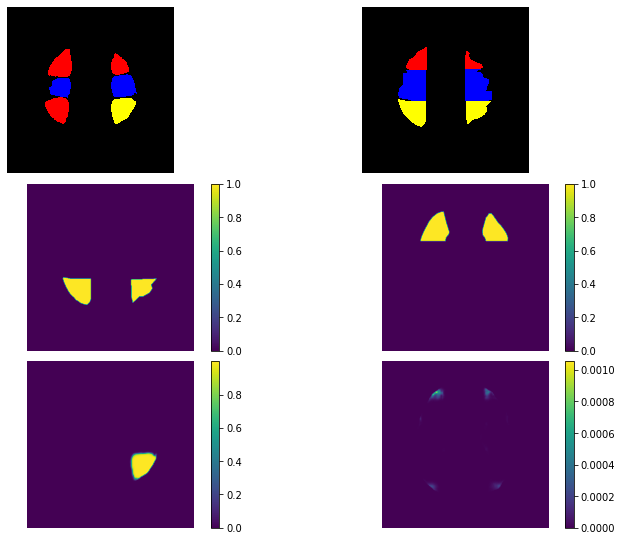


Epoch: 7
train:  58%|█████▊    | 319/550 [05:02<03:32,  1.09it/s, BCE + LogDice loss - 0.2918, iou_score - 0.7891]

In [ ]:
max_score = 0

for i in range(0, 156):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(data_loader_train)
    clear_output()
    model.eval()
    with torch.no_grad():
        masks = list()
        predictions = list()
        for idx in range(len(dataset_validation)):
            data = dataset_validation[idx]
            image = torch.autograd.Variable(torch.tensor(data[0]).unsqueeze(0)).cuda()
            predictions.append(model(image).cpu().numpy()[0])
            masks.append(data[1])
    predictions = torch.Tensor(np.array(predictions))
    masks = torch.Tensor(np.array(masks))
    metric_iou = iou(predictions, masks)
    print(iou.exam(predictions, masks))
    print('IoU: {}'.format(metric_iou))

    scheduler.step(metric_iou, epoch=i)

    if max_score < metric_iou:
        max_score = metric_iou
        torch.save(model, './best_model.pth')
        print('saving')
        
    fig=plt.figure(figsize=(10, 10))
    model.eval()
    with torch.no_grad():
        image = torch.autograd.Variable(torch.tensor(dataset_validation[76][0]).unsqueeze(0)).cuda()
        prediction = torch.nn.functional.sigmoid(model(image))

        prednew = torch.argmax(prediction.cpu(), dim=1) + 1
        prednew[prediction.max(1)[0]<0.5] = 0

        fig.add_subplot(4, 2, 1)
        plt.axis('off')
        io.imshow(color.label2rgb(np.asarray(prednew.detach().cpu().squeeze()), bg_label=0))

        valid = np.argmax(dataset_validation[76][1], axis=0)
        fig.add_subplot(4, 2, 2)
        plt.axis('off')
        io.imshow(color.label2rgb(valid, bg_label=0))

        image = torch.autograd.Variable(torch.tensor(dataset_validation[76][0]).unsqueeze(0)).cuda()
        prediction = torch.nn.functional.sigmoid(model(image))
        fig.add_subplot(4, 2, 5)
        a = plt.imshow(prediction[0,6,:,:].cpu())
        plt.axis('off')
        plt.colorbar(a)

        image = torch.autograd.Variable(torch.tensor(dataset_validation[60][0]).unsqueeze(0)).cuda()
        prediction = torch.nn.functional.sigmoid(model(image))
        fig.add_subplot(4, 2, 6)
        plt.axis('off')
        a = plt.imshow(prediction[0,4,:,:].cpu())
        plt.colorbar(a)



    fig.add_subplot(4, 2, 3)
    a = plt.imshow(dataset_validation[76][1][6])
    plt.axis('off')
    plt.colorbar(a)

    fig.add_subplot(4, 2, 4)
    a = plt.imshow(dataset_validation[60][1][4])
    plt.axis('off')
    plt.colorbar(a)



    plt.show()


    

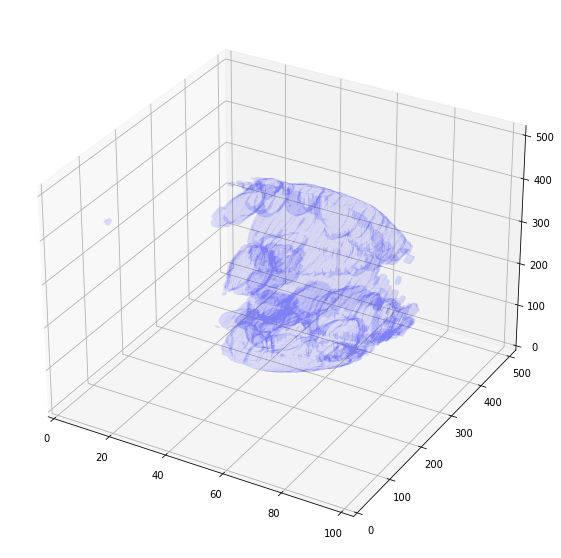

In [45]:
with torch.no_grad():
    predictions = list()
    for idx in range(len(dataset_validation)):
        data = dataset_validation[idx]
        image = torch.autograd.Variable(torch.tensor(data[0]).unsqueeze(0)).cuda()
        prediction = torch.sigmoid(model(image))

        prednew = torch.argmax(prediction.cpu(), dim=1) + 1
        prednew[prediction.max(1)[0] < 0.5] = 0
        predictions.append(prednew.numpy()[0])
predictions = np.array(predictions)
plot_predictions(predictions)